# Вариант 4. Сравнение GAP и Flatten

**Цель:** Понимание различий между Flatten и Global Average Pooling.

- Спроектируйте сеть с 3 свёрточными слоями, после которых выходной тензор `(batch, 128, 8, 8)`.
- **Условие:** Реализуйте два варианта классификации:
  1. `Flatten → Linear`
  2. `Global Average Pooling → Linear`
- **Эксперимент:** Обучите оба варианта на данных и сравните дисперсию выходных активаций перед финальным слоем.

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [140]:
class NetFlatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.convLayer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.convLayer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.activation = nn.ReLU()
        self.linear = nn.Linear(in_features=128*8*8, out_features=10)
        
    def forward(self, x):
        x = self.convLayer1(x)
        x = self.activation(x)
        
        x = self.convLayer2(x)
        x = self.activation(x)
        
        x = self.convLayer3(x)
        x = self.activation(x)
        
        x = torch.flatten(x, 1)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        return x

In [141]:
class NetGAP(nn.Module):
    def __init__(self):
        super().__init__()
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.convLayer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.convLayer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.activation = nn.ReLU()
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = self.convLayer1(x)
        x = self.activation(x)
        
        x = self.convLayer2(x)
        x = self.activation(x)
        
        x = self.convLayer3(x)
        x = self.activation(x)
        
        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        return x

In [142]:
models = [NetFlatten(), NetGAP()]
model_names = ['Flatten', 'GAP']

# batch=1, channel=3, size=32x32
test_tensor = torch.randn(1, 3, 32, 32)

for mdl in models:
    print(mdl(test_tensor).shape)
    #print(mdl(test_tensor))

torch.Size([1, 10])
torch.Size([1, 10])


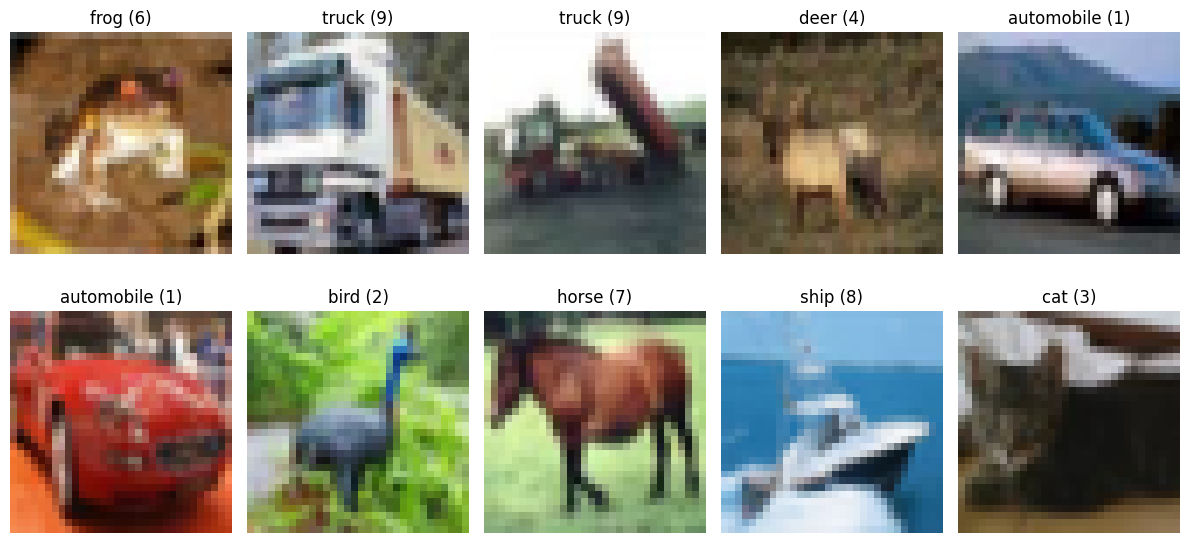

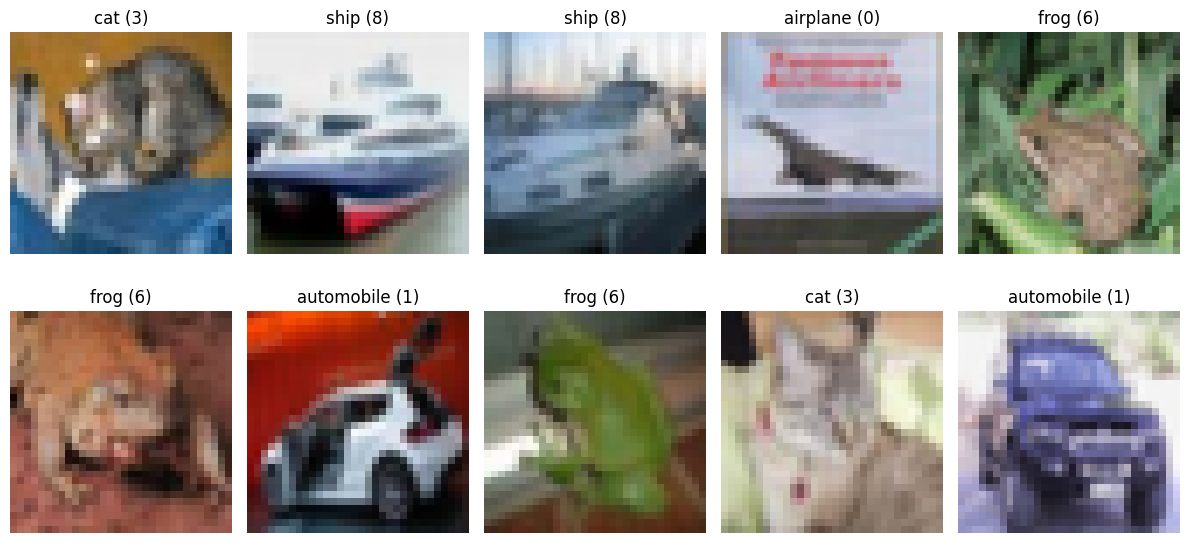

In [143]:
# Подгрузим данные для последующего обучения

from torchvision import datasets, transforms
from tqdm import tqdm

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=None)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_images):
        image, label = dataset[i]
        
        axes[i].imshow(image)
        axes[i].set_title(f'{classes[label]} ({label})')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


show_images(train_dataset)

show_images(test_dataset)

In [144]:
print("Размер обучающего датасета:", len(train_dataset))
print("Размер тестового датасета:", len(test_dataset))

Размер обучающего датасета: 50000
Размер тестового датасета: 10000


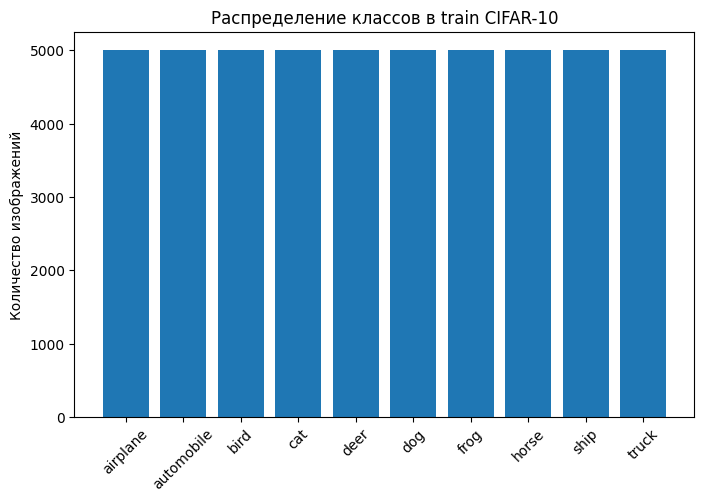

In [145]:
from collections import Counter

train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

plt.figure(figsize=(8,5))
plt.bar(classes, [class_counts[i] for i in range(10)])
plt.title("Распределение классов в train CIFAR-10")
plt.xticks(rotation=45)
plt.ylabel("Количество изображений")
plt.show()

In [146]:
# Цикл обучения
from torch.optim import Adam
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


model = NetFlatten()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        train_losses.append(loss)
        loss.backward()
        
        optimizer.step()
        
    print(f'loss: {sum(train_losses)/ len(train_losses)}')
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {sum(train_losses)/ len(train_losses)}')

100%|██████████| 782/782 [00:34<00:00, 22.66it/s]


loss: 2.101585626602173
Epoch [1/5], Loss: 2.101585626602173


100%|██████████| 782/782 [00:42<00:00, 18.49it/s]


loss: 2.0508368015289307
Epoch [2/5], Loss: 2.0508368015289307


100%|██████████| 782/782 [00:45<00:00, 17.29it/s]


loss: 2.01981258392334
Epoch [3/5], Loss: 2.01981258392334


100%|██████████| 782/782 [00:49<00:00, 15.83it/s]


loss: 1.9967045783996582
Epoch [4/5], Loss: 1.9967045783996582


100%|██████████| 782/782 [00:43<00:00, 17.96it/s]


loss: 1.977321743965149
Epoch [5/5], Loss: 1.977321743965149
